In [345]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from workalendar.europe import Belgium
import itertools
import sys
# Deep learning: 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import model_from_json
import itertools
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(threshold=sys.maxsize)

In [76]:
holidata = pd.read_pickle('./building1_holidays.pkl')
holidata.index = holidata.index.tz_localize(None)

In [3]:
holidata = pd.read_csv('./Consumption_15min.csv', index_col=0)
holidata.index = pd.to_datetime(holidata.index)
holidata.index = holidata.index.tz_localize(None)

In [5]:
granularity = holidata.index.inferred_freq
print(granularity)

15T


In [119]:
holidata_user = holidata[-672*30+96*2:-672*29+96*2]
holidata_user.to_csv(deep_learner.import_file_path, index=True)
holidata_user.head()

,Valeur
Datetime,
2019-06-07 00:00:00,6.30
2019-06-07 00:15:00,5.88
2019-06-07 00:30:00,6.30
2019-06-07 00:45:00,6.09
2019-06-07 01:00:00,6.30


In [75]:
holidata_user = holidata[-672*3+96*0:-672*2+96*0]
holidata_user.to_csv('./building1_input2.csv', index=True)
holidata_user.to_csv(deep_learner.import_file_path, index=True)

NameError: name 'holidata' is not defined

In [9]:
holidata_user = holidata[-672*38+96*3:-672*37+96*3]
holidata_user.to_csv(deep_learner.import_file_path, index=True)

In [264]:
test_range = holidata[-672*2+96*0:-672*1+96*0]
test_range

,Valeur
Datetime,
2019-12-18 00:00:00,5.25
2019-12-18 00:15:00,5.25
2019-12-18 00:30:00,5.88
2019-12-18 00:45:00,5.25
2019-12-18 01:00:00,4.41
...,...
2019-12-24 22:45:00,4.20
2019-12-24 23:00:00,3.99
2019-12-24 23:15:00,3.78


In [81]:
test_range = holidata[-672*29+96*2:-672*28+96*2]
test_range

,Datetime,Valeur,working day
Datetime,,,
2019-06-14 00:00:00,2019-06-14 00:00:00,6.09,True
2019-06-14 00:15:00,2019-06-14 00:15:00,6.09,True
2019-06-14 00:30:00,2019-06-14 00:30:00,6.51,True
2019-06-14 00:45:00,2019-06-14 00:45:00,5.88,True
2019-06-14 01:00:00,2019-06-14 01:00:00,5.88,True
...,...,...,...
2019-06-20 22:45:00,2019-06-20 22:45:00,4.41,True
2019-06-20 23:00:00,2019-06-20 23:00:00,3.99,True
2019-06-20 23:15:00,2019-06-20 23:15:00,3.78,True


In [346]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        #data: pd.DataFrame,
        data_path: str,
        Y_var: str,
        model_save: str,
        model_load: str,
        import_file_path: str,
        export_file_path: str,
        lag: int,
        lag2: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        n_test = 96,
        holi_var = 'working day',
        hour_var_sin = 'hour of day_sin',
        hour_var_cos = 'hour of day_cos',
        day_week_sin = 'day of week_sin',
        day_week_cos = 'day of week_cos',
        month_sin = 'month_sin',
        month_cos = 'month_cos',
        minutes_sin = 'minutes_sin',
        minutes_cos = 'minutes_cos',

    ):
        
        self.data_path = data_path
        self.data = pd.read_csv(data_path, index_col=0)
        #self.data = data
        self.import_file_path = import_file_path
        self.data_user = pd.read_csv(import_file_path, index_col=0)
        self.data_user.index = pd.to_datetime(self.data_user.index)
        self.model_save = model_save
        self.model_load = model_load
        self.export_file_path = export_file_path
        self.Y_var = Y_var 
        self.holi_var = holi_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.lag2 = lag2
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.n_test = n_test
    
    @staticmethod
    def get_fractional_hour_from_series(series: pd.Series) -> pd.Series:
        """
        Return fractional hour in range 0-24, e.g. 12h30m --> 12.5.
        Accurate to 1 minute.
        """
        hour = series.dt.hour
        minute = series.dt.minute
        return hour + minute / MINUTES_IN_HOUR

    @staticmethod
    def get_fractional_day_from_series(series: pd.Series) -> pd.Series:
        """
        Return fractional day in range 0-1, e.g. 12h30m --> 0.521.
        Accurate to 1 minute
        """
        fractional_hours = get_fractional_hour_from_series(series)
        return fractional_hours / HOURS_IN_DAY

    @staticmethod
    def get_fractional_year_from_series(series: pd.Series) -> pd.Series:
        """
        Return fractional year in range 0-1.
        Accurate to 1 day
        """
        return (series.dt.dayofyear - 1) / 365

    def preprocess(self, dataframe):
        dataframe.index = pd.to_datetime(dataframe.index)
        # Removing duplicates
        dataframe = dataframe[~dataframe.index.duplicated()]
        
        #Filling NaN values
        dataframe = dataframe.interpolate()
        
        cal = Belgium()
        #years = list(range(2014, 2025))
        #holidays = []
        #for year in years:
        #    holidays.extend(cal.holidays(year))
        dataframe = dataframe.sort_index()
        dataframe[self.Y_var] = dataframe.iloc[:,0]
        dataframe['working day'] = dataframe.index.map(cal.is_working_day)
        dataframe['hour of day'] = dataframe.index.hour
        dataframe['day of week'] = dataframe.index.dayofweek
        dataframe['date'] = dataframe.index.date
        dataframe['month'] = dataframe.index.month
        dataframe['minutes'] = dataframe.index.minute
        # we encode cynical data into two dimensions using a sine and cosine transformations
        def encode(data, col, max_val):
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
            return data
        dataframe = encode(dataframe, 'hour of day', 23)
        dataframe = encode(dataframe, 'day of week', 6)
        dataframe = encode(dataframe, 'month', 12)
        dataframe = encode(dataframe, 'minutes', 60)
        dataframe = dataframe.drop(['hour of day', 'day of week', 'month', 'minutes'], axis=1)
        dataframe = dataframe.fillna(method='ffill')
        return dataframe
    
    @staticmethod    
    def plot_train_history(model):
        '''
        Convergence plots to have an idea on how the training performs
        '''
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']
        plt.figure()
        plt.plot(range(len(loss)), loss, 'b', label='Training loss')
        plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
        #plt.yscale("log")
        plt.xlabel('Epochs')
        plt.ylabel('Losses')
        plt.title('Training and validation losses')
        plt.legend()
        plt.show() 
    
    @staticmethod
    def validation(forecasted, real, parameter):
        ''' 
        compute some important parameters to compare forecasting results
        '''
        value = 0
        value_1 = 0
        value_2 = 0

        if parameter == 'SMAPE':
            for i in range(len(forecasted)):
                if real[i] + forecasted[i] == 0:
                    value += 0
                else: 
                    value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
            final_value = value / len(forecasted)  

        elif parameter == 'MAPE':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (abs(real[i] - forecasted[i]))/real[i]
            final_value = value / len(forecasted) * 100

        elif parameter == 'RMSE':
            for i in range(len(forecasted)):
                value += (real[i] - forecasted[i]) ** 2
            final_value = (value / len(forecasted)) ** (1 / 2) 

        elif parameter == 'R':
            for i in range(len(forecasted)):
                value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
                value_1 += (real[i] - np.mean(real)) ** 2
                value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

            if value_1 == 0 or value_2 == 0:
                final_value = 100
            else:
                final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

        return final_value
        
    @staticmethod
    def create_X_Y(ts: list, holiday: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int, lag2: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag2):
                Y.append(ts[i + lag2])
                # Substacted 96 for not knowing the day before
                #ab = list(itertools.chain([holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]]))
                #ab = list(itertools.chain([ts[i+lag - lag]], [ts[i+lag - lag2]], [holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]]))
                #ab = list(itertools.chain([ts[i+lag2 - lag]], [ts[i+lag2 - lag2]], [holiday[i + lag2]], [hour_cos[i + lag2]], [hour_sin[i + lag2]], [week_cos[i + lag2]], [week_sin[i + lag2]], [minute_cos[i + lag2]], [minute_sin[i + lag2]], [month_cos[i + lag2]], [month_sin[i + lag2]]))
                #ab = list(itertools.chain([ts[i+lag2 - lag]*holiday[i + lag2]], [ts[i+lag2 - lag2]], [max(ts[i+lag2-2*lag:i+lag2-lag])*holiday[i + lag2]], [holiday[i + lag2]], [hour_cos[i + lag2]], [hour_sin[i + lag2]], [week_cos[i + lag2]], [week_sin[i + lag2]], [minute_cos[i + lag2]], [minute_sin[i + lag2]], [month_cos[i + lag2]], [month_sin[i + lag2]]))                
                ab = list(itertools.chain([ts[i+lag2 - lag]*holiday[i + lag2]], [ts[i+lag2 - lag2]], [max(ts[i+lag2-2*lag:i+lag2-lag])*holiday[i + lag2]], [holiday[i + lag2]], [hour_cos[i + lag2]], [hour_sin[i + lag2]], [week_cos[i + lag2]], [week_sin[i + lag2]], [month_cos[i + lag2]], [month_sin[i + lag2]]))                                
                X.append(ab)
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None, ahead=False):
        """
        A method to create data for the neural network model
        """
        self.data = self.preprocess(self.data)
        #print(self.data.columns.values)
        
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]
            y_holiday = y_holiday[-use_last_n:]
            y_hour_cos = y_hour_cos[-use_last_n:]
            y_hour_sin = y_hour_sin[-use_last_n:]
            y_weekday_cos = y_weekday_cos[-use_last_n:]
            y_weekday_sin = y_weekday_sin[-use_last_n:]
            y_month_cos = y_month_cos[-use_last_n:]
            y_month_sin = y_month_sin[-use_last_n:]
            y_minute_cos = y_minute_cos[-use_last_n:]
            y_minute_sin =  y_minute_sin[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)

        # Creating training and test sets 
        X_train = X
        X_val = []
        X_test = []

        Y_train = Y
        Y_val = []
        Y_test = []
        if ahead == False:
            if self.train_test_split > 0:
                index = len(X) - self.n_test
                X_train = X[:round(index * (1-self.train_test_split))]
                X_val = X[round(index * (1-self.train_test_split)):index]
                X_test = X[-self.n_test:]     
                
                Y_train = Y[:round(index * (1-self.train_test_split))]
                Y_val = Y[round(index * (1-self.train_test_split)):index]
                Y_test = Y[-self.n_test:]
        print(X_train.shape)
        print(Y_train.shape)
        #print(X_val.shape)
        #print(Y_val.shape)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
   
    def save_model(self, model):
        model_json = model.to_json()
        with open(self.model_save+'.json', "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(self.model_save+'.h5')
          
    def load_model(self):
        # load json and create model
        json_file = open(self.model_load+".json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights(self.model_load+".h5")
        print("Loaded model from disk")
    
    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_val, X_test, Y_train, Y_val, Y_test = self.create_data_for_NN()
        #print(X_test)

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='msle')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=30)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_val, Y_val)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model
        # Plotting train history
        self.plot_train_history(model)
        # Saving the model in json and h5
        self.save_model(self.model)
        
        return model  

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, _, X_test, _, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat
    
    def plot_test(self):
        yhat = self.predict()# Constructing the forecast dataframe
        fc = self.data.tail(len(yhat)).copy()
        fc['forecast'] = yhat
        expected = fc.loc[:,'Valeur']
        predictions = fc.loc[:,'forecast']
        print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        # Ploting the forecasts
        plt.figure(figsize=(12, 8))
        for dtype in ['Valeur', 'forecast']:  
            plt.plot(fc.index, fc[dtype],label=dtype,alpha=0.7)
        plt.legend()
        plt.grid()

        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption for test data", fontsize=20)

        plt.show()
    
    def predict_n_ahead(self, data_input, n_ahead: int):
        dates = pd.date_range(data_input.index[-1], periods = n_ahead+1, freq='15T')[1:]
        test = data_input.append(pd.DataFrame(index=dates))
        test.index=data_input.index.union(dates)
        test = self.preprocess(test)
        y = test[self.Y_var].tolist()
        y_holiday = test[self.holi_var].tolist()
        y_hour_cos = test[self.hour_var_cos].tolist()
        y_hour_sin = test[self.hour_var_sin].tolist()
        y_weekday_cos = test[self.day_week_cos].tolist()
        y_weekday_sin = test[self.day_week_sin].tolist()
        y_month_cos = test[self.month_cos].tolist()
        y_month_sin = test[self.month_sin].tolist()
        y_minute_cos = test[self.minutes_cos].tolist()
        y_minute_sin = test[self.minutes_sin].tolist()
        yhat = []
        X, _ = deep_learner.create_X_Y(y, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)
        yhat = [y[0] for y in self.model.predict(X)]
        return yhat[-n_ahead:]
    
    def evaluate_n_ahead(self, n_ahead: int):
        data_temp = self.data_user
        yhat = []
        predictions = []
        if hasattr('self', 'model') == False:
            self.load_model()
        for i in tf.range(n_ahead//96+1):
            y_hat = self.predict_n_ahead(data_temp, self.lag)
            data_temp = data_temp.append(pd.DataFrame(y_hat, columns=['Valeur'], index=pd.date_range(data_temp.index[-1], periods = self.lag+1, freq='15T')[1:]))
            data_temp.drop(data_temp.head(self.lag).index, inplace=True)
            predictions.extend(y_hat)
        #print(len(predictions))
        predictions = predictions[:n_ahead]
        #print(len(predictions))
        dates = pd.date_range(self.data_user.index[-1], periods = n_ahead+1, freq='15T')[1:]
        #print(len(dates))
        #print(len(predictions))
        test = pd.DataFrame(predictions)
        test.index = dates
        test.index = pd.to_datetime(test.index)
        test.to_csv(self.export_file_path, index=True)
        expected = test_range.head(n_ahead).loc[:,"Valeur"]
        predictions = test.iloc[:,0]
        #print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        #print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        plt.figure(figsize=(25, 10))
        plt.grid()
        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption forecast for given days ahead", fontsize=20)
        plt.plot(test_range.index, test_range.loc[:,"Valeur"], color='orange', label='test', alpha=0.7)
        plt.plot(self.data_user.index, self.data_user.loc[:,"Valeur"], color='b', label='user input data', alpha=0.5)
        plt.plot(test.index, test.iloc[:,0], color='black', linestyle='--', linewidth=3, label='Forecaster model',alpha=0.7)
        plt.legend(prop={'size': 20})
        return test

In [347]:
deep_learner = DeepModelTS(
# USER INPUT SETTINGS
Y_var = 'Valeur',
model_load = "model_B1_complete",
import_file_path = './building1_input.csv',
export_file_path = './predictions.csv',
# TRAINING SETTINGS
data_path = '../data/Columbia_clean/Residential_2.csv',
#data = holidata,
model_save = "model_B1_complete",
lag = 24,
lag2 = 168,
LSTM_layer_depth = 64,
epochs = 100,
batch_size = 128,
train_test_split = 0.15,
n_test = 168
)

(25416, 1, 10)
(25416,)
Epoch 1/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0462 - val_loss: 0.0287
Epoch 2/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0335 - val_loss: 0.0273
Epoch 3/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0324 - val_loss: 0.0353
Epoch 4/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0321 - val_loss: 0.0250
Epoch 5/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0316 - val_loss: 0.0408
Epoch 6/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0247
Epoch 7/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0314 - val_loss: 0.0282
Epoch 8/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0311 - val_loss: 0.0296
Epoch 9/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0310 - val_loss: 0.0245
Epoch 10/100
199/199 [==============================] - 1s 5ms/step

199/199 [==============================] - 1s 6ms/step - loss: 0.0278 - val_loss: 0.0268
Epoch 82/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0265
Epoch 83/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0278 - val_loss: 0.0272
Epoch 84/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0268
Epoch 85/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0269
Epoch 86/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 87/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0269
Epoch 88/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0273
Epoch 89/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0276 - val_loss: 0.0262
Epoch 90/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0276 - val_loss: 

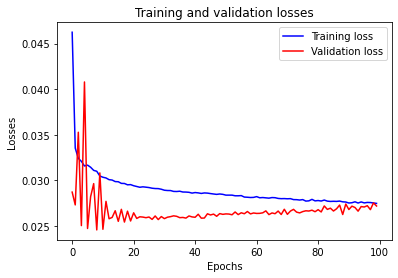

In [348]:
# Fitting the model
model = deep_learner.LSTModel ()

(25416, 1, 10)
(25416,)
RMSE: 0.268693 [kWh]
MAPE: 52.146352 %


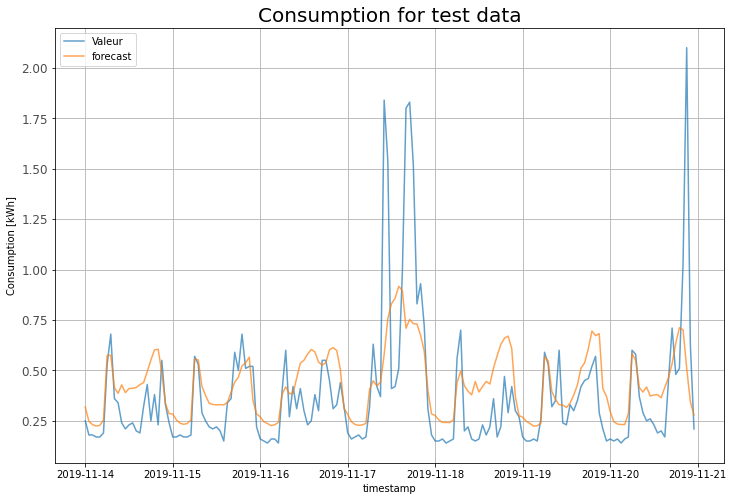

In [349]:
deep_learner.plot_test()

Loaded model from disk


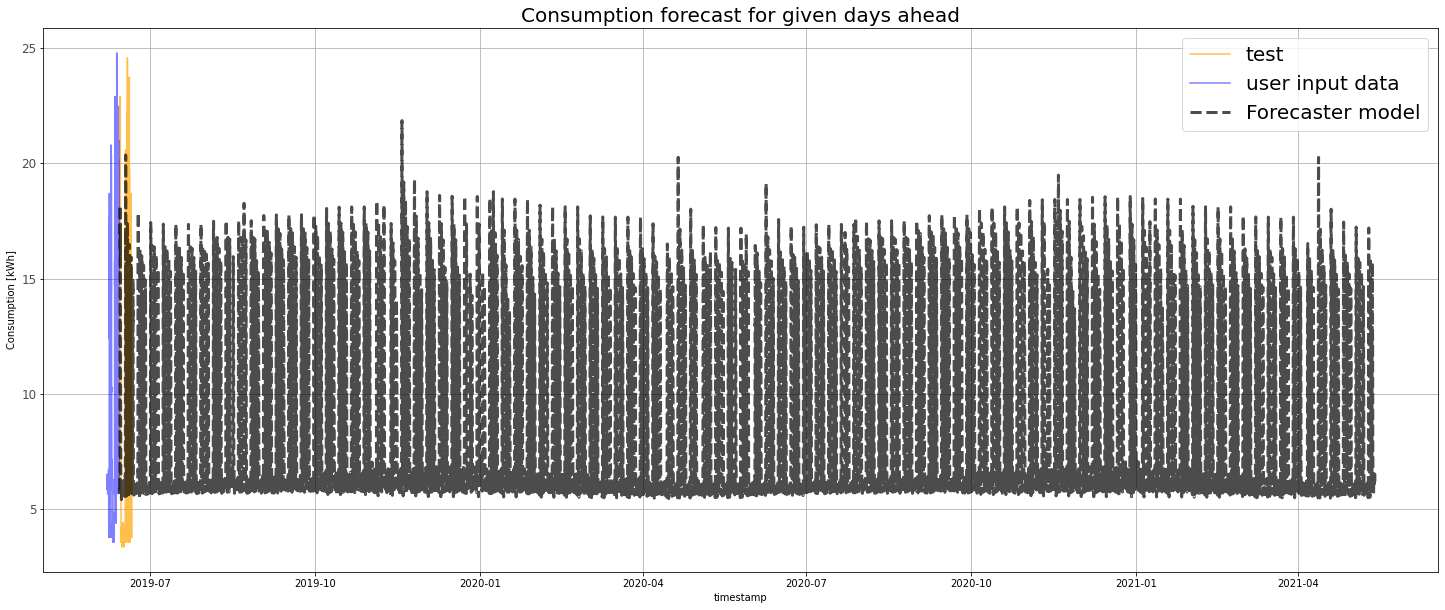

In [193]:
deep_learner.test = deep_learner.evaluate_n_ahead(672*100)